In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import json
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
# Load pretrained ResNet-34
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()
model = model.cuda()

Set dataset path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/dl_project3/TestDataSet"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from pathlib import Path
from torchvision import transforms

class ImageFolderRecursive(ImageFolder):
    def find_classes(self, directory):
        return super().find_classes(directory)
    def make_dataset(self, directory, class_to_idx,
                     extensions=None, is_valid_file=None, allow_empty=False):
        if extensions is None:
            extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp')
        instances = []
        directory = Path(directory)
        for cls_name, cls_idx in class_to_idx.items():
            tgt = directory / cls_name
            for p in tgt.rglob('*'):
                if p.is_file() and p.suffix.lower() in extensions:
                    instances.append((str(p), cls_idx))
        if len(instances) == 0 and not allow_empty:
            raise FileNotFoundError('No valid images found')
        return instances

mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset_path = '/content/drive/MyDrive/dl_project3/TestDataSet'
dataset = ImageFolderRecursive(root=dataset_path,
                               transform=plain_transforms,
                               loader=default_loader)

print(len(dataset), len(dataset.classes))

388 100


In [ ]:
# Load label mapping from labels_list.json
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    raw_labels = json.load(f)

# Build mapping: class_idx -> ImageNet index, and ImageNet index -> label name
idx_to_imagenet_idx = {}
imagenet_idx_to_label = {}
for i, item in enumerate(raw_labels):
    imagenet_index, label_name = item.split(": ")
    idx_to_imagenet_idx[i] = int(imagenet_index)
    imagenet_idx_to_label[int(imagenet_index)] = label_name

In [ ]:
# Define custom dataset wrapper to relabel targets
class RelabeledDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, idx_map):
        self.base_dataset = base_dataset
        self.idx_map = idx_map

    def __getitem__(self, index):
        image, label = self.base_dataset[index]
        new_label = self.idx_map[label]
        return image, new_label

    def __len__(self):
        return len(self.base_dataset)


In [ ]:
# Create dataloader with relabeled targets
relabeled_dataset = RelabeledDataset(dataset, idx_to_imagenet_idx)
dataloader = torch.utils.data.DataLoader(relabeled_dataset, batch_size=16, shuffle=False)


# Task 1 : Evaluate pretrained ResNet-34 on the clean test dataset

In [ ]:
# Evaluation function with label mapping
def evaluate_model(model, dataloader, idx_to_imagenet_idx, imagenet_idx_to_label, device='cuda'):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            # Top-1 accuracy
            top1_preds = top5_preds[:, 0]
            top1_correct += (top1_preds == labels).sum().item()

            # Top-5 accuracy
            for i in range(labels.size(0)):
                if labels[i] in top5_preds[i]:
                    top5_correct += 1

            total += labels.size(0)

    top1_acc = top1_correct / total
    top5_acc = top5_correct / total

    print(f"Top-1 Accuracy: {top1_acc:.4f}")
    print(f"Top-5 Accuracy: {top5_acc:.4f}")
    return top1_acc, top5_acc

In [ ]:
# Move the model to GPU
model = model.to('cuda')

# Run Task 1 baseline evaluation
print("Evaluating ResNet-34 on clean TestDataSet...")
top1_clean, top5_clean = evaluate_model(
    model,
    dataloader,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

# Save baseline result for later comparison
baseline_results = {
    "top1": top1_clean,
    "top5": top5_clean
}

Evaluating ResNet-34 on clean TestDataSet...
Top-1 Accuracy: 0.6881
Top-5 Accuracy: 0.9381


# Task 2 : Pixel-wise attacks

In [ ]:

# FGSM attack implementation
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad_sign = images.grad.data.sign()
    perturbed = images + epsilon * grad_sign
    perturbed = torch.clamp(perturbed, 0, 1)  # Ensure valid pixel range
    return perturbed.detach()

# Generate Adversarial Test Set 1
epsilon = 0.02
adv_images_all = []
adv_labels_all = []

print(f"Generating adversarial examples with ε = {epsilon} ...")
model.eval()
for images, labels in tqdm(dataloader):
    images, labels = images.to('cuda'), labels.to('cuda')
    adv_images = fgsm_attack(model, images, labels, epsilon)
    adv_images_all.append(adv_images.cpu())
    adv_labels_all.append(labels.cpu())

# Combine into a new dataset
adv_images_all = torch.cat(adv_images_all)
adv_labels_all = torch.cat(adv_labels_all)
adv_dataset = TensorDataset(adv_images_all, adv_labels_all)
adv_loader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

# Evaluate adversarial performance
print("Evaluating on Adversarial Test Set 1 (FGSM)...")
top1_adv, top5_adv = evaluate_model(
    model,
    adv_loader,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

# Save for reporting
fgsm_results = {
    "top1": top1_adv,
    "top5": top5_adv,
    "epsilon": epsilon
}

Generating adversarial examples with ε = 0.02 ...


100%|██████████| 25/25 [00:04<00:00,  5.88it/s]


Evaluating on Adversarial Test Set 1 (FGSM)...
Top-1 Accuracy: 0.2216
Top-5 Accuracy: 0.4149


Visualize 5 test cases where the original model no longer classifies as expected.

In [ ]:
from torchvision.models import ResNet34_Weights

# match ID# to labels
# Load full 1000 ImageNet class names
weights = ResNet34_Weights.IMAGENET1K_V1
imagenet_1k_labels = weights.meta["categories"]

# Unified label lookup: prefer custom, fallback to ImageNet-1K
def get_label_name(class_idx):
    if class_idx in imagenet_idx_to_label:
        return imagenet_idx_to_label[class_idx]
    elif 0 <= class_idx < len(imagenet_1k_labels):
        return imagenet_1k_labels[class_idx]
    else:
        return f"ID {class_idx}"


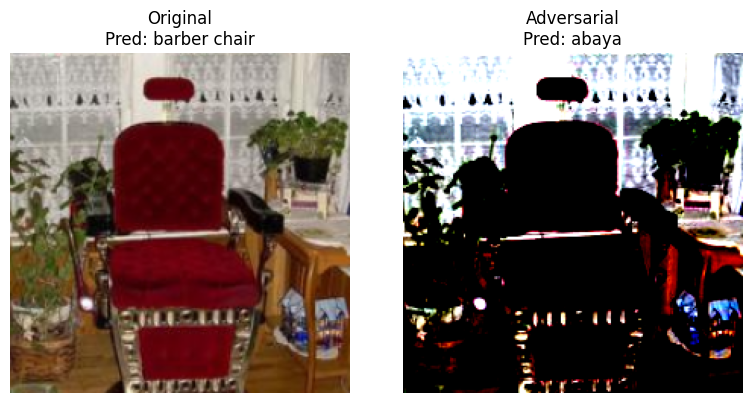

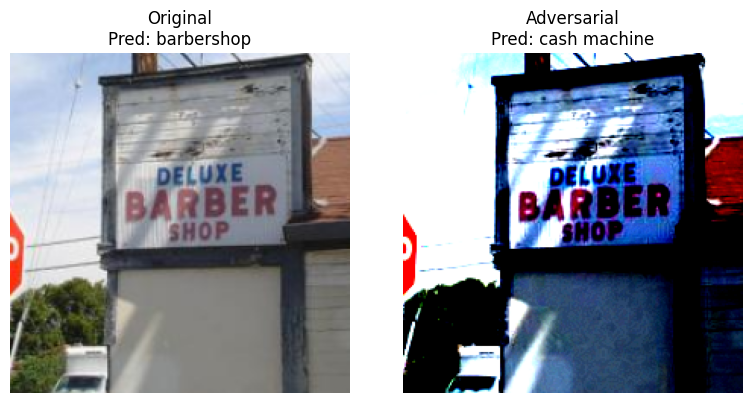

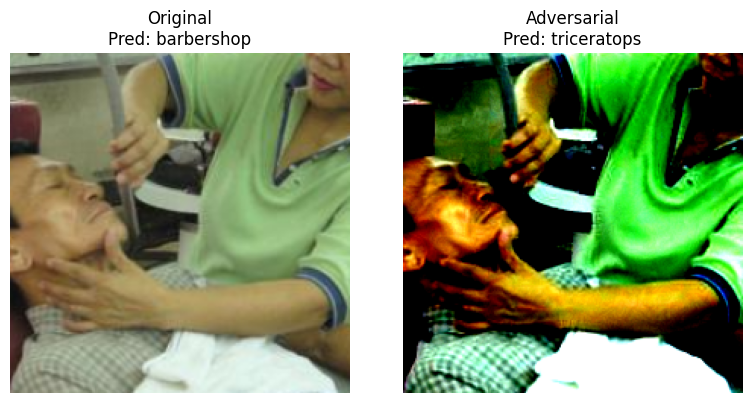

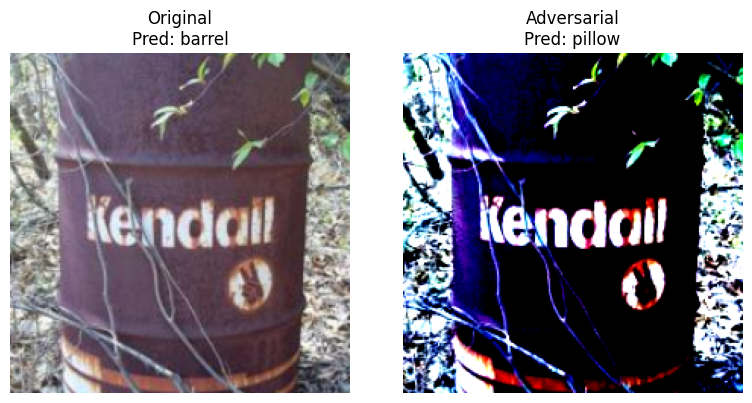

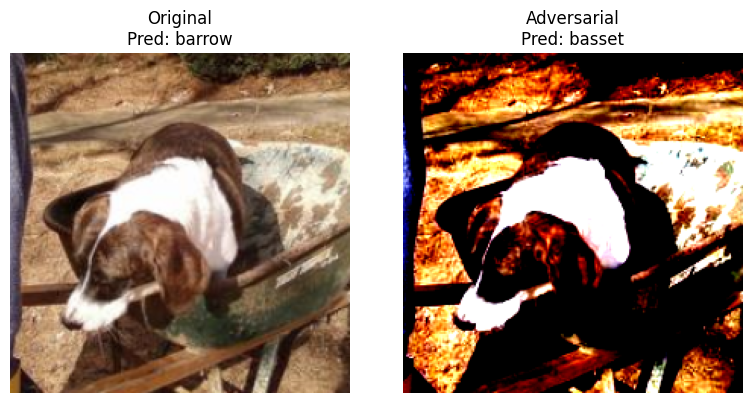

In [ ]:
# Helper: denormalize the image tensor
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clamp(img_tensor * std + mean, 0, 1)

# Prepare to collect 5 misclassified examples
shown = 0
for i in range(len(relabeled_dataset)):
    image, true_label = relabeled_dataset[i]
    adv_image, adv_label = adv_dataset[i]

    image = image.unsqueeze(0).to('cuda')
    adv_image = adv_image.unsqueeze(0).to('cuda')

    model.eval()
    with torch.no_grad():
        clean_pred = model(image).argmax(dim=1).item()
        adv_pred = model(adv_image).argmax(dim=1).item()

    if clean_pred == true_label and adv_pred != true_label:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        img1 = denormalize(image.squeeze().cpu()).permute(1, 2, 0).numpy()
        img2 = adv_image.squeeze().cpu().permute(1, 2, 0).numpy()

        axs[0].imshow(img1)
        axs[0].axis('off')
        axs[1].imshow(img2)
        axs[1].axis('off')

        # Handle missing labels safely
        orig_label = get_label_name(clean_pred)
        adv_label = get_label_name(adv_pred)
        axs[0].set_title(f"Original\nPred: {orig_label}")
        axs[1].set_title(f"Adversarial\nPred: {adv_label}")

        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= 5:
            break

plt.show()

In [ ]:
torch.save({
    'images': adv_images_all,
    'labels': adv_labels_all
}, 'adv_test_set_1.pt')


# Task 3 :

In [ ]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch

# PGD
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    ori = images.clone().detach()
    adv = images.clone().detach()

    for _ in range(iters):
        adv.requires_grad = True
        outputs = model(adv)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Gradient sign step
        adv = adv + alpha * adv.grad.sign()
        # Project back into the ε-ball and clip to [0,1]
        delta = torch.clamp(adv - ori, min=-epsilon, max=epsilon)
        adv = torch.clamp(ori + delta, 0, 1).detach()

    return adv

In [ ]:
# Generate Adversarial Test Set 2
eps   = 0.02      # 与 FGSM 保持一致的 ε，可自行调大
alpha = 0.005     # 步长
steps = 10        # 迭代次数

print(f'Generating PGD adversarial set (ε={eps}, α={alpha}, steps={steps}) …')
adv_imgs, adv_lbls = [], []
model.eval()
for imgs, lbls in tqdm(dataloader):
    imgs, lbls = imgs.to('cuda'), lbls.to('cuda')
    adv = pgd_attack(model, imgs, lbls, epsilon=eps, alpha=alpha, iters=steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(lbls.cpu())

adv_imgs = torch.cat(adv_imgs)
adv_lbls = torch.cat(adv_lbls)
adv_dataset_2 = TensorDataset(adv_imgs, adv_lbls)
adv_loader_2  = DataLoader(adv_dataset_2, batch_size=16, shuffle=False)

# Evaluate PGD effectiveness
print('Evaluating on Adversarial Test Set 2 (PGD)…')
top1_pgd, top5_pgd = evaluate_model(
    model,
    adv_loader_2,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

pgd_results = {
    'top1': top1_pgd,
    'top5': top5_pgd,
    'epsilon': eps,
    'alpha': alpha,
    'steps': steps
}
print(pgd_results)
# Save the dataset for Task 4
torch.save({'images': adv_imgs, 'labels': adv_lbls}, 'adv_test_set_2.pt')

Generating PGD adversarial set (ε=0.02, α=0.005, steps=10) …


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Evaluating on Adversarial Test Set 2 (PGD)…
Top-1 Accuracy: 0.0052
Top-5 Accuracy: 0.0335
{'top1': 0.005154639175257732, 'top5': 0.03350515463917526, 'epsilon': 0.02, 'alpha': 0.005, 'steps': 10}


# Task4：

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
from tqdm import tqdm

# Randomly generate batch-level patch mask
def rand_patch_mask(bs, h, w, patch=32, device='cuda'):
    mask = torch.zeros(bs, 1, h, w, device=device)
    ys = torch.randint(0, h - patch + 1, (bs,), device=device)
    xs = torch.randint(0, w - patch + 1, (bs,), device=device)
    for i in range(bs):
        mask[i, :, ys[i]:ys[i]+patch, xs[i]:xs[i]+patch] = 1.
    return mask

def patch_pgd(model, imgs, lbls, eps=0.5, alpha=0.1, steps=40, psize=32):
    ori  = imgs.clone().detach()
    bs, c, h, w = ori.shape
    mask = rand_patch_mask(bs, h, w, psize, imgs.device).repeat(1, c, 1, 1)
    adv  = ori.clone().detach()

    for _ in range(steps):
        adv.requires_grad_(True)
        loss = F.cross_entropy(model(adv), lbls)
        model.zero_grad()
        loss.backward()
        grad = adv.grad.sign()

        # Only update the patch region
        adv = adv + alpha * mask * grad
        delta = torch.clamp(adv - ori, -eps, eps)
        adv   = torch.clamp(ori + delta * mask + ori * (1 - mask), 0, 1).detach()

    return adv

In [ ]:
eps, alpha, steps, psize = 0.5, 0.1, 40, 32
print(f'Generating Patch-PGD set (ε={eps}, α={alpha}, steps={steps}, patch={psize}) …')
p_imgs, p_lbls = [], []
model.eval()
for imgs, lbls in tqdm(dataloader):
    imgs, lbls = imgs.to('cuda'), lbls.to('cuda')
    adv = patch_pgd(model, imgs, lbls, eps, alpha, steps, psize)
    p_imgs.append(adv.cpu())
    p_lbls.append(lbls.cpu())

p_imgs = torch.cat(p_imgs)
p_lbls = torch.cat(p_lbls)
adv_dataset_3 = TensorDataset(p_imgs, p_lbls)
adv_loader_3  = DataLoader(adv_dataset_3, batch_size=16, shuffle=False)

# evaluation
print('Evaluating on Adversarial Test Set 3 (Patch-PGD)…')
top1_patch, top5_patch = evaluate_model(
    model,
    adv_loader_3,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

patch_results = {
    'top1': top1_patch,
    'top5': top5_patch,
    'epsilon': eps,
    'alpha': alpha,
    'steps': steps,
    'patch': psize
}
print(patch_results)

# save the dataset
torch.save({'images': p_imgs, 'labels': p_lbls}, 'adv_test_set_3.pt')

Generating Patch-PGD set (ε=0.5, α=0.1, steps=40, patch=32) …


100%|██████████| 25/25 [01:22<00:00,  3.31s/it]


Evaluating on Adversarial Test Set 3 (Patch-PGD)…
Top-1 Accuracy: 0.0515
Top-5 Accuracy: 0.2062
{'top1': 0.05154639175257732, 'top5': 0.20618556701030927, 'epsilon': 0.5, 'alpha': 0.1, 'steps': 40, 'patch': 32}


# Task5：

In [ ]:
from torchvision.models import densenet121, vit_b_16, DenseNet121_Weights, ViT_B_16_Weights
from torch.utils.data import DataLoader

def load_model_and_trans(name):
    if name == 'densenet':
        w = DenseNet121_Weights.IMAGENET1K_V1
        m = densenet121(weights=w).to('cuda').eval()
    else:
        w = ViT_B_16_Weights.IMAGENET1K_V1
        m = vit_b_16(weights=w).to('cuda').eval()
    return m

# DataLoaders
clean_loader = dataloader                    # Task1
fgsm_loader  = adv_loader                    # Task2
pgd_loader   = adv_loader_2                  # Task3
patch_loader = adv_loader_3                  # Task4
sets = [('clean',  clean_loader),
        ('fgsm',   fgsm_loader),
        ('pgd',    pgd_loader),
        ('patch',  patch_loader)]

results_transfer = {}

for model_name in ['densenet', 'vit']:
    model = load_model_and_trans(model_name)
    print(f'\n== {model_name.upper()} ==')
    res = {}
    for tag, loader in sets:
        print(f'  {tag} … ', end='', flush=True)
        t1, t5 = evaluate_model(model, loader,
                                idx_to_imagenet_idx,
                                imagenet_idx_to_label,
                                device='cuda')
        res[tag] = {'top1': t1, 'top5': t5}
    results_transfer[model_name] = res

print('\nTransfer summary')
print(results_transfer)
torch.save(results_transfer, 'transfer_results.pt')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


== DENSENET ==
  clean … 

Top-1 Accuracy: 0.6804
Top-5 Accuracy: 0.9149
  fgsm … Top-1 Accuracy: 0.3376
Top-5 Accuracy: 0.6005
  pgd … Top-1 Accuracy: 0.2887
Top-5 Accuracy: 0.5515
  patch … Top-1 Accuracy: 0.2474
Top-5 Accuracy: 0.5103


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 184MB/s]



== VIT ==
  clean … Top-1 Accuracy: 0.8814
Top-5 Accuracy: 0.9871
  fgsm … Top-1 Accuracy: 0.5747
Top-5 Accuracy: 0.8093
  pgd … Top-1 Accuracy: 0.5696
Top-5 Accuracy: 0.7990
  patch … Top-1 Accuracy: 0.4716
Top-5 Accuracy: 0.6856

Transfer summary
{'densenet': {'clean': {'top1': 0.6804123711340206, 'top5': 0.9149484536082474}, 'fgsm': {'top1': 0.33762886597938147, 'top5': 0.6005154639175257}, 'pgd': {'top1': 0.28865979381443296, 'top5': 0.5515463917525774}, 'patch': {'top1': 0.24742268041237114, 'top5': 0.5103092783505154}}, 'vit': {'clean': {'top1': 0.8814432989690721, 'top5': 0.9871134020618557}, 'fgsm': {'top1': 0.5747422680412371, 'top5': 0.8092783505154639}, 'pgd': {'top1': 0.5695876288659794, 'top5': 0.7989690721649485}, 'patch': {'top1': 0.47164948453608246, 'top5': 0.6855670103092784}}}


表格

In [ ]:
import pandas as pd

# ResNet-34 baseline & results under three types of attacks
resnet_df = pd.DataFrame({
    'Dataset':    ['Clean', 'FGSM', 'PGD', 'Patch‑PGD'],
    'Top‑1 Acc':  [baseline_results['top1'], fgsm_results['top1'],
                   pgd_results['top1'],      patch_results['top1']],
    'Top‑5 Acc':  [baseline_results['top5'], fgsm_results['top5'],
                   pgd_results['top5'],      patch_results['top5']],
    'ε':          [0, fgsm_results['epsilon'],
                   pgd_results['epsilon'],   patch_results['epsilon']],
    'Steps':      [0, 1,
                   pgd_results['steps'],    patch_results['steps']]
})
print("### ResNet‑34 Adversarial Results")
print(resnet_df.to_markdown(index=False))

# Transfer evaluation table (DenseNet-121 & ViT-B/16)
rows = []
for model_name, res in results_transfer.items():
    clean1 = res['clean']['top1']
    clean5 = res['clean']['top5']
    for tag in ['fgsm', 'pgd', 'patch']:
        rows.append({
            'Model':      model_name.upper(),
            'Attack':     tag.upper(),
            'Clean Top‑1': clean1,
            'Adv Top‑1':  res[tag]['top1'],
            'Drop‑1 (%)': (clean1 - res[tag]['top1'])/clean1*100,
            'Clean Top‑5': clean5,
            'Adv Top‑5':  res[tag]['top5'],
            'Drop‑5 (%)': (clean5 - res[tag]['top5'])/clean5*100,
        })
transfer_df = pd.DataFrame(rows)
print("\n### Transfer Evaluation Results")
print(transfer_df.to_markdown(index=False))

### ResNet‑34 Adversarial Results
| Dataset   |   Top‑1 Acc |   Top‑5 Acc |    ε |   Steps |
|:----------|------------:|------------:|-----:|--------:|
| Clean     |  0.688144   |   0.938144  | 0    |       0 |
| FGSM      |  0.221649   |   0.414948  | 0.02 |       1 |
| PGD       |  0.00515464 |   0.0335052 | 0.02 |      10 |
| Patch‑PGD |  0.0515464  |   0.206186  | 0.5  |      40 |

### Transfer Evaluation Results
| Model    | Attack   |   Clean Top‑1 |   Adv Top‑1 |   Drop‑1 (%) |   Clean Top‑5 |   Adv Top‑5 |   Drop‑5 (%) |
|:---------|:---------|--------------:|------------:|-------------:|--------------:|------------:|-------------:|
| DENSENET | FGSM     |      0.680412 |    0.337629 |      50.3788 |      0.914948 |    0.600515 |      34.3662 |
| DENSENET | PGD      |      0.680412 |    0.28866  |      57.5758 |      0.914948 |    0.551546 |      39.7183 |
| DENSENET | PATCH    |      0.680412 |    0.247423 |      63.6364 |      0.914948 |    0.510309 |      44.2254 |
| VIT    

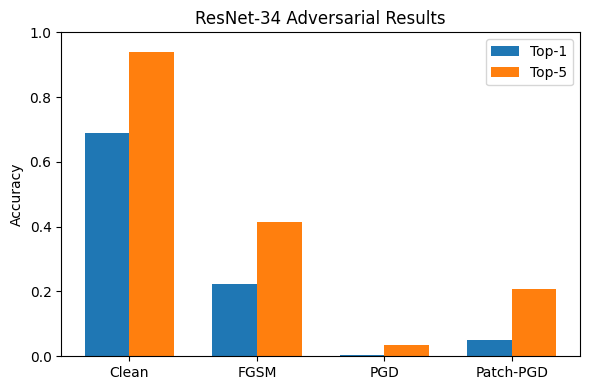

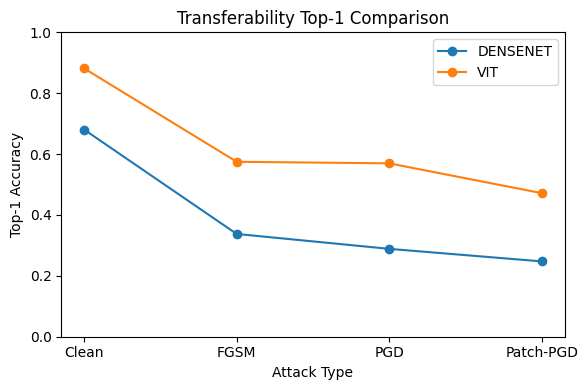

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ResNet-34 adversarial results
labels = ['Clean', 'FGSM', 'PGD', 'Patch-PGD']
top1 = [baseline_results['top1'], fgsm_results['top1'],
        pgd_results['top1'],      patch_results['top1']]
top5 = [baseline_results['top5'], fgsm_results['top5'],
        pgd_results['top5'],      patch_results['top5']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, top1, width, label='Top‑1')
plt.bar(x + width/2, top5, width, label='Top‑5')
plt.xticks(x, labels)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('ResNet‑34 Adversarial Results')
plt.legend()
plt.tight_layout()
plt.show()

# Top‑1 line plot comparison
models = ['DENSENET','VIT']
attacks = ['clean','fgsm','pgd','patch']
attack_labels = ['Clean','FGSM','PGD','Patch-PGD']

plt.figure(figsize=(6,4))
for m in models:
    vals = [results_transfer[m.lower()][a]['top1'] for a in attacks]
    plt.plot(attack_labels, vals, marker='o', label=m)
plt.ylim(0,1)
plt.xlabel('Attack Type')
plt.ylabel('Top‑1 Accuracy')
plt.title('Transferability Top‑1 Comparison')
plt.legend()
plt.tight_layout()
plt.show()